<a href="https://www.kaggle.com/code/hikmatullahmohammadi/mnist-digit-classification-cnn?scriptVersionId=115562785" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id='0'></a>
# Deep MNIST Digit Classification Using TF & Keras (CNN)

<h2>Table of contents</h2>
<ol>
    <li><a href='#1'>Load and discover the dataset</a></li>
    <li><a href='#2'>Preprocess the dataset</a></li>
    <li><a href='#3'>Data visualization</a></li>
    <li><a href='#4'>Modeling</a></li>
    <li><a href='#5'>Prediction and submission</a></li>
</ol>

In [1]:
# import required libraries/dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

<a id='1'></a>
## Load and discover the dataset

Since the dataset is in 'csv' format, I prefer to load it as a DataFrame using pandas library. Then, I will prepare it, so that it is understood & accepted by the Keras API.

In [2]:
# the train set and the test set paths
train_path = '/kaggle/input/digit-recognizer/train.csv'
test_path = '/kaggle/input/digit-recognizer/test.csv'

In [3]:
# read the files using pd
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [4]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As you can see, the dataset is comprised of **785 columns** the first one being the corresponding **label**.

Each observation has **784** features (pixels). That's because each image in the dataset is (28 x 28), but pixels values are flattened, and because **28 times 28 equals 784**, it has 784 features. We will later change (reshape) the values from (1x784) to (28x28) to represent an image.

---

<a id='2'></a>
## Preprocess the dataset

**Preprocessing the dataset in order to make it ready-to-use for the Keras API**

Here I will divide the dataset into two parts, the features and the labels (X and y)

In [5]:
X = df_train.drop('label', axis=1)
y = df_train['label']

In order for the Keras API to recognize our dataset, we need to do the followings:<br>
- Convert the data points from Pandas DataFrame/Series to Numpy Arrays
- Reshape the images to represent a real image. (each single image should be reshaped to (28x28) [to be showed properly])

In [6]:
X = X.to_numpy()
y = y.to_numpy()
df_test = df_test.to_numpy()

# reshape
X = X.reshape(-1, 28, 28, 1) # Read the explanations bellow
df_test = df_test.reshape(-1, 28, 28, 1)

**(-1, 28, 28, 1) why this? <br>**
- -1 means any number (in this case, any number of rows (e.g. 28,000)).<br>
- 28 in height and 28 in width.<br>
- the last 1 represents the number of channels; here since the images are in grayscale, they only have one channel.

Now, I will convert the dataset from numpy arrays to Tensorflow/Keras Datasets. In other words, we will create the TF dataset from the numpy arrays (X_train, y_train, df_test.)

In [7]:
# split the datset into test set and validation set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=11)

In [8]:
# create the dataset from numpy arrays
ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((df_test, ))

2023-01-05 11:42:18.436365: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:42:18.437262: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:42:18.446538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:42:18.447329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-05 11:42:18.448134: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [9]:
# this cell will divide our datasets into batches of 64 images each
ds_train = ds_train.batch(64, drop_remainder=True)
ds_val = ds_val.batch(64, drop_remainder=True)
ds_test = ds_test.batch(64)

<a id='3'></a>
## Data Visualization

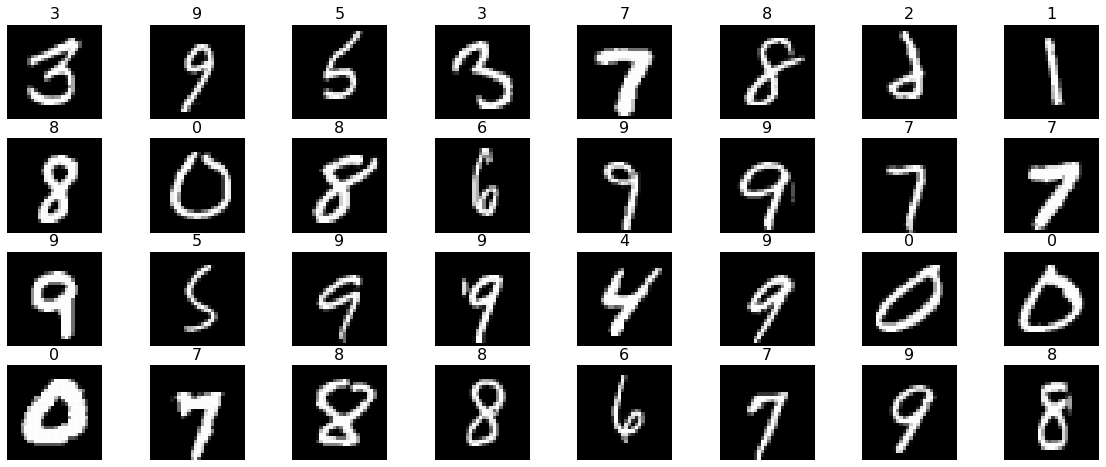

In [10]:
# visvalize some images from the training set
ds_batch = ds_train.take(1).as_numpy_iterator()

plt.figure(figsize=(20, 8))
for images, labels in ds_batch:
    for i in range(32):
        plt.subplot(4, 8, i+1)
        img = keras.preprocessing.image.array_to_img(images[i])
        plt.imshow(img, cmap='gray')
        plt.title(str(labels[i]), fontdict={'fontsize':16})
        plt.axis('off')

<a id='4'></a>
## Modeling

Now, we will build our CNN model to trian on the training set, and we will use it to predict the test set.

In [11]:
# build the model structure
model = keras.models.Sequential([  
    # preprocessing layer
    keras.layers.Rescaling(scale=1./255, input_shape=(28, 28, 1)),
    
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    
    keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D(pool_size=(2, 2
                                        ), strides=2),
    
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax')
])

In [12]:
# compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0

In [14]:
# train the model
epochs = 32
model.fit(ds_train, validation_data=ds_val, epochs=epochs)

Epoch 1/32


2023-01-05 11:42:31.380906: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-05 11:42:32.028041: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


590/590 [==============================] - 5s 3ms/step - loss: 0.2928 - accuracy: 0.9140 - val_loss: 0.0974 - val_accuracy: 0.9695
Epoch 2/32
590/590 [==============================] - 2s 3ms/step - loss: 0.0733 - accuracy: 0.9776 - val_loss: 0.0715 - val_accuracy: 0.9796
Epoch 3/32
590/590 [==============================] - 2s 3ms/step - loss: 0.0506 - accuracy: 0.9843 - val_loss: 0.0545 - val_accuracy: 0.9839
Epoch 4/32
590/590 [==============================] - 2s 3ms/step - loss: 0.0376 - accuracy: 0.9879 - val_loss: 0.0472 - val_accuracy: 0.9880
Epoch 5/32
590/590 [==============================] - 2s 3ms/step - loss: 0.0299 - accuracy: 0.9904 - val_loss: 0.0482 - val_accuracy: 0.9863
Epoch 6/32
590/590 [==============================] - 2s 3ms/step - loss: 0.0242 - accuracy: 0.9922 - val_loss: 0.0516 - val_accuracy: 0.9875
Epoch 7/32
590/590 [==============================] - 2s 3ms/step - loss: 0.0209 - accuracy: 0.9931 - val_loss: 0.0483 - val_accuracy: 0.9863
Epoch 8/32
590/59

<a id='5'></a>
## Prediction and Submission

In [15]:
preds = model.predict(ds_test)

In [16]:
preds = np.argmax(preds, -1)

In [17]:
submission = pd.DataFrame(
    {
        'ImageId': np.arange(1, preds.shape[0]+1),
        'Label': preds
    }
)
submission.to_csv('./submission.csv', index=False)

# Thank you!
<h5><a href='#0'>Top</a></h5>